# Big data tools for MD simulation analysis

Trajectories are sets of coordinates over time.
While the act of gathering data and conducting simulations are exhaustively parallelized, some analysis methods are not.
Speaking from experience, parallelizing analysis using [Python multiprocessing](https://docs.python.org/3.7/library/multiprocessing.html) can get very messy if you don't have a clear idea of how you want to parallelize the analysis, and how exactly you're going to code it up.

## Some big data tools

Since grad school, I've been exposed to a variety of big data tools (Dask, Spark, Rapids), and it's been a point of interest to test their utility to molecular simulation.
Each tool comes with its own sets of advantages and disadvantages, and I encourage everyone to actively try each to see which is most appropriate for the desired application.

* Rapids is very fast, but requires GPUs. Depending on your tech stack and tech constraints, you may or may not have cheap and easy access to sufficient GPUs. Rapids is a little more sensitive to data types than others - but as an amateur, I could be misusing the libraries.
* Spark is fast, but requires some hadoop and spark knowhow to make properly. Many tech stacks and constraints seem to be well-suited for spark applications. Spark scales out well, very flexible with datatypes, and eschews a lot of parallel programming-knowhow. At work, some primitive tests have shown that spark outperforms dask for dataframe operations on strings and some ML operations - but as an amateur, there is probably some dask tuning that could be done
* Dask is also fast, but your mileage may vary. Some tech stacks are suitable for Dask, but cloud resources/tech constraints might make Dask adoption hard. Dask exposes various levels of parallelism, so proper Dask-users will end up learning a lot about parallel computing along the way.

## For those like me who are not used to setting up parallel compute
The one thing I will observe as I dabble away on my personal computer - I am neither familiar with setting up a Hadoop cluster nor am I familiar with exposing my WSL to my GPU. 
If given the proper infrastructure and resources, I can use these libraries, but at this moment it would take time for me to set up the resources to properly utilizes Spark or Rapids on my PC.
Dask, in my case, seems like the simplest parallel compute library to use.
If you're a grad student or a data scientist unfamiliar with software environments and infrastructure beyond Conda environments, Dask might also be easiest for adoption.

## Computing atomic distances from a molecular dynamics simulation
Trivial MD analysis involves looking at each atom within a frame, and not having to look at time correlations from frame to frame.
I'm going to use [MDTraj](https://github.com/mdtraj/mdtraj/) to load in a trajectory, and look at distances between atoms in each frame. 
I'll do this serial, with just MDTraj, and I'll do this with using one level of Dask parallelism, [Dask delayed](https://docs.dask.org/en/latest/delayed.html)

In [1]:
import mdtraj
import dask
from dask import delayed
import dask.bag as db


Saving myself the effort of generating my own trajectory, I will use [one of the trajectories in MDTraj's unit tests](https://github.com/mdtraj/mdtraj/tree/master/tests/data)

In [2]:
from pathlib import Path

path_to_data = Path('/home/ayang41/programs/mdtraj/tests/data')
tip3p_xtc = Path.joinpath(path_to_data/'tip3p_300K_1ATM.xtc')
tip3p_pdb = Path.joinpath(path_to_data/'tip3p_300K_1ATM.pdb')

This trajectory is only 401 frames - parallel analysis incurs too much overhead to be useful.
I'm going to artificially lengthen the trajectory out to 1604 frames, where the gain from parallelization will hopefully be more apparent.
In reality, most grad students will have many, many more frames to analyze.

In [6]:
traj = mdtraj.load(tip3p_xtc.as_posix(), top=tip3p_pdb.as_posix())
for i in range(2):
    traj = traj.join(traj)
traj

<mdtraj.Trajectory with 1604 frames, 774 atoms, 258 residues, and unitcells at 0x7f5940cd0950>

Additionally, to load up the computational expense, I'll look at all pairwise atomic distances in each frame

In [7]:
import itertools as it
import numpy as np
atom_pairs = [*it.permutations(np.arange(0, traj.n_atoms),2)]

## Simple implementation with MDTraj

On my PC with 6 cores, this took about 29.2 seconds (and also nearly froze my computer).

It should be noted that MDTraj already does a lot of parallelization and acceleration under their hood with some C optimizations.
"Simple" in this case, is a user depending on MDTraj's optimizations

In [8]:
%%time

displacements = mdtraj.compute_displacements(traj, atom_pairs)

CPU times: user 5.98 s, sys: 11.9 s, total: 17.9 s
Wall time: 29.2 s


## Combining Dask with MDTraj

Like most parallel computing applications, it's important to recognize how and what you will be parallelizing/distributing.
In this case, we will be distributing our one trajectory across 4 partitions, creating `Delayed` objects.
Each `Delayed` object isn't an actual execution - it's a scheduled operation (like queueing something up in SLURM or PBS)

In [26]:
%%time
bag = db.from_sequence(traj, npartitions=4)
bunch_of_delayed = bag.to_delayed()

CPU times: user 5.59 s, sys: 1.2 s, total: 6.8 s
Wall time: 6.81 s


In [27]:
bag

dask.bag<from_sequence, npartitions=4>

In [28]:
bunch_of_delayed

[Delayed(('from_sequence-88fe68aacc4a7e0a97311de0f2bfaf0f', 0)),
 Delayed(('from_sequence-88fe68aacc4a7e0a97311de0f2bfaf0f', 1)),
 Delayed(('from_sequence-88fe68aacc4a7e0a97311de0f2bfaf0f', 2)),
 Delayed(('from_sequence-88fe68aacc4a7e0a97311de0f2bfaf0f', 3))]

If we wanted to, we can still pluck out and execute the `Delayed` objects, and parse the number of atoms in MDTraj-like syntax

In [29]:
bunch_of_delayed[0].compute()[0].n_atoms

774

To queue up additional computations, we will take each `Delayed` object, and add on one additional operation - `mdtraj.compute_displacements`.
Now the delayed objects have two operations - distributing the trajectory and computing the displacements

Again, the computation has not been performed yet

In [30]:
%%time
all_displacements = [delayed(mdtraj.compute_displacements)(traj[0], atom_pairs) for traj in bunch_of_delayed]
all_displacements

CPU times: user 20 s, sys: 1.62 s, total: 21.6 s
Wall time: 21.6 s


[Delayed('compute_displacements-d9b79031-6b0d-480f-b349-8614d1eec647'),
 Delayed('compute_displacements-bf96ea1d-12c4-4554-80c3-dd2aa7c54329'),
 Delayed('compute_displacements-25aa9fe2-4855-47a5-ba62-8ebca46f699f'),
 Delayed('compute_displacements-637dd1cc-9cc1-488e-9192-3f51011095f7')]

If we want to "flush" the queue and run all our `Delayed` computations, we use Dask to finally compute them.

At this point, the actual calculation took 12.6 seconds, but the overhead involved 21.6 seconds

In [31]:
%%time
displacements = dask.compute(all_displacements)

CPU times: user 12.3 s, sys: 234 ms, total: 12.6 s
Wall time: 12.6 s


## Visualizing the dask graph

Spark and Dask both use task graphs to schedule function after function, with Spark doing some implicit optimizations.

Dask has a nice visualize functionality to show what the task graphs and parallelization look like

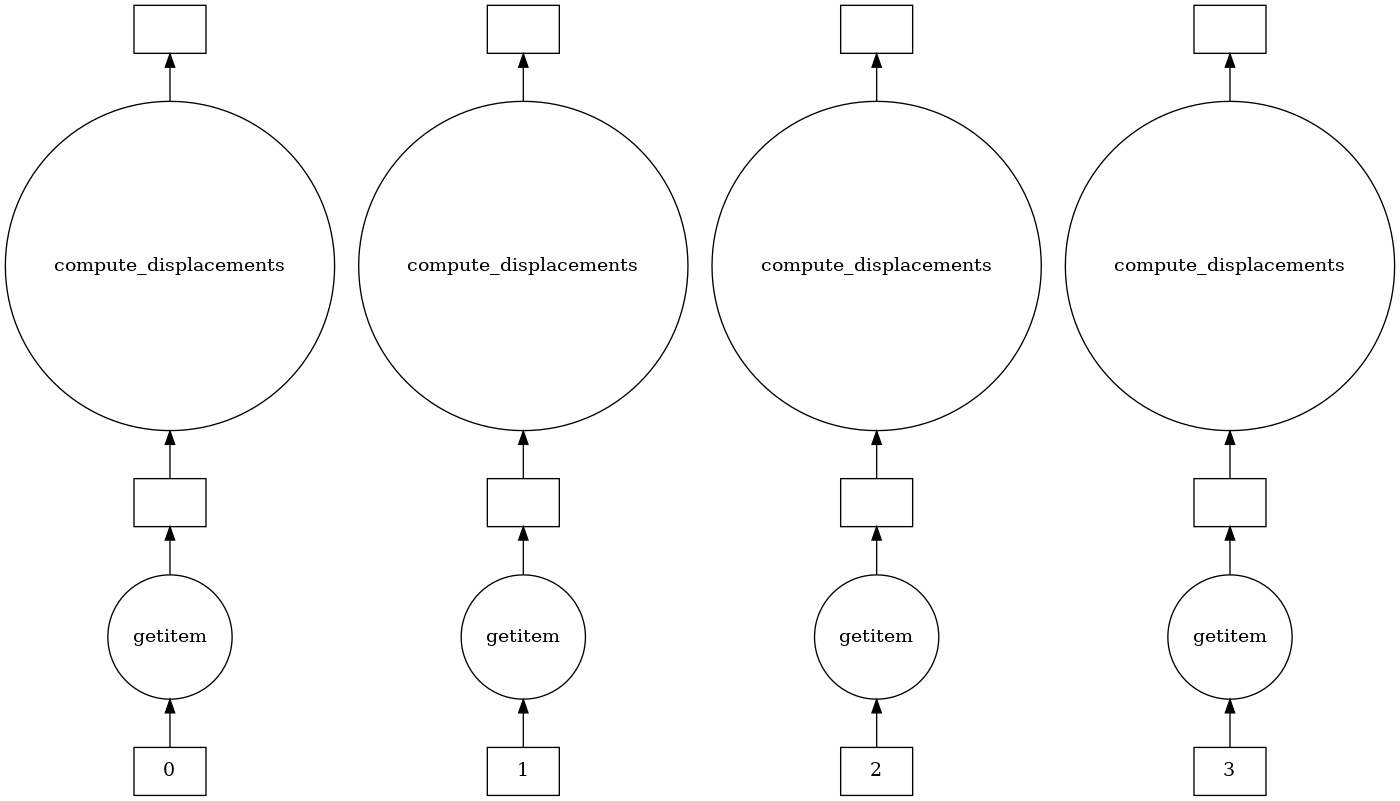

In [32]:
dask.visualize(all_displacements)